# Evaluation Notebook

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import os
import pickle

from typing import Union, Literal

from eval import read_run_dir, get_err_from_run, compute_scaling_err, get_timed_err_from_run
from plot_utils import plot_model_errs

%matplotlib inline
%load_ext autoreload
%autoreload 2

# sns.set_theme('notebook', 'darkgrid')
# palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
1,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
4,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
3,pretrained_relu,linear_regression,Transformer-ReLU,,-1,-1,20,12,8,linear_regression_standard
0,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
2,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [3]:
task: Union[
    Literal["linear_regression"], 
    Literal["sparse_linear_regression"], 
    Literal["decision_tree"], 
    Literal["relu_2nn_regression"]
] = "linear_regression"

models = df[df.task == task].reset_index(drop=True)
models["run_path"] = models.apply(lambda row: os.path.join(run_dir, row['task'], row['run_id']), axis=1)
models

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name,run_path
0,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained,../models/linear_regression/pretrained
1,pretrained_relu,linear_regression,Transformer-ReLU,,-1,-1,20,12,8,linear_regression_standard,../models/linear_regression/pretrained_relu


## Plot Generation

We will now directly load the model and measure its in-context learning ability on a larger batch of random inputs. (We expand the batch size to obtain better estimates)

### Setup

In [4]:
bs_x = lambda factor: (lambda bs: bs * factor)
bs = lambda batch_size: (lambda _: batch_size)
scale = lambda factor: (lambda x: x * factor)

optimals = {
    "linear_regression" : {
        "error": torch.concat((torch.arange(20, -1, -1), torch.zeros((20, )))),
        "label" : "Least Squares"
    },
    "sparse_linear_regression" : {
        "error" : torch.concat((torch.arange(20, -1, -1), torch.zeros((20, )))), # TODO: I'm not sure this is the known optimal approach
        "label" : "Least Squares",
    }
}

### Error across all models

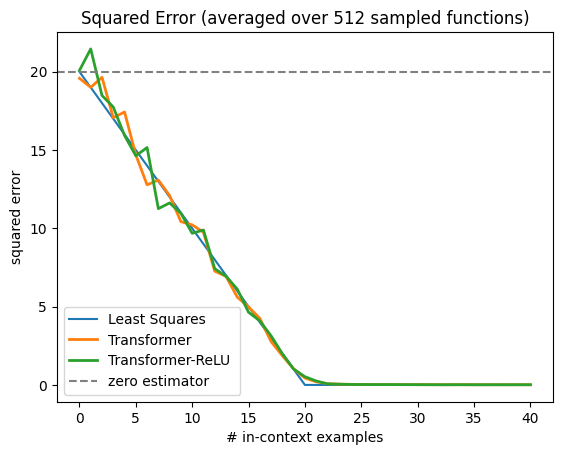

In [86]:
BATCH_SIZE = 512
plt.title(f"Squared Error (averaged over {BATCH_SIZE} sampled functions)")

if task in optimals.keys():
    plt.plot(optimals[task]["error"], label=optimals[task]["label"])

plot_model_errs(
    { 
        row["model"] : get_err_from_run(
            row["run_path"], 
            mutate_bs=bs(BATCH_SIZE)
        )
        for _, row in models.iterrows() 
    },
    baseline=20, no_std_dev=True
)

### Doubling Inputs

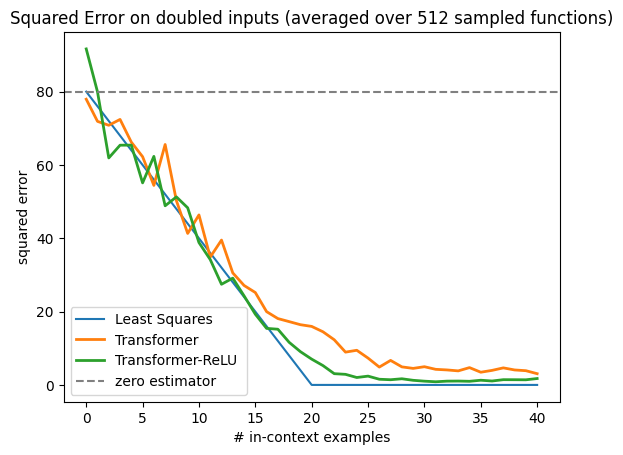

In [85]:
BATCH_SIZE = 512
double = scale(2)

plt.title(f"Squared Error on doubled inputs (averaged over {BATCH_SIZE} sampled functions)")

if task in optimals.keys():
    plt.plot(optimals[task]["error"] * double(1)**2, label=optimals[task]["label"])

plot_model_errs(
    { 
        row["model"] : get_err_from_run(
            row["run_path"], 
            mutate_xs=double, mutate_bs=bs(BATCH_SIZE)
        )
        for _, row in models.iterrows() 
    },
    baseline=20 * double(1)**2, no_std_dev=True
)

### Halving Inputs

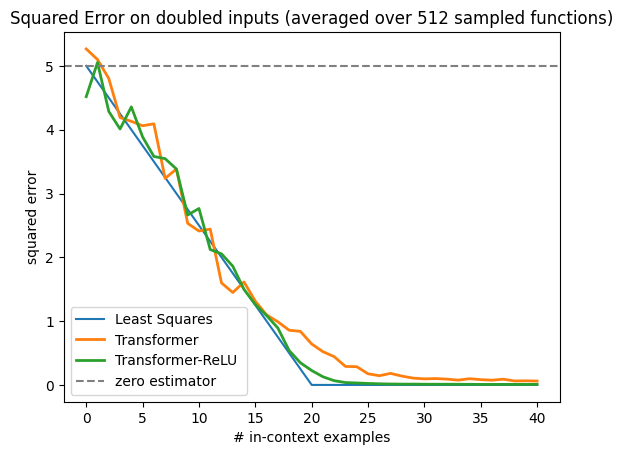

In [83]:
BATCH_SIZE = 512
halve = scale(0.5)

plt.title(f"Squared Error on halved inputs (averaged over {BATCH_SIZE} sampled functions)")

if task in optimals.keys():
    plt.plot(optimals[task]["error"] * halve(1)**2, label=optimals[task]["label"])

plot_model_errs(
    { 
        row["model"] : get_err_from_run(
            row["run_path"], 
            mutate_xs=halve, mutate_bs=bs(BATCH_SIZE)
        )
        for _, row in models.iterrows() 
    },
    baseline=20 * halve(1)**2, no_std_dev=True
)

### Varying scaling factor

In [ ]:
scales = np.concatenate((np.arange(0.1, 1, 0.1), np.arange(1, 11.)))
vanil_scale_loss = compute_scaling_err("../models/linear_regression/pretrained", scales=scales)
relu_scale_loss = compute_scaling_err(run_path, scales=scales)

In [ ]:
EXAMPLES = [10, 15, 20, 25, 30]

fig, ax = plt.subplots(1, len(EXAMPLES), sharey='all')
fig.set_size_inches(20, 5)
for i, ic_examples in enumerate(EXAMPLES):
    relu_l = relu_scale_loss.swapaxes(-1, 0)[ic_examples]
    vanil_l = vanil_scale_loss.swapaxes(-1, 0)[ic_examples]

    ax[i].plot(scales, relu_l.mean(axis=0), label="ReLU")
    ax[i].plot(scales, vanil_l.mean(axis=0), label="Vanilla")

    ax[i].set_title(f"Error with {ic_examples} examples")
    ax[i].set_xscale('log')
    ax[i].set_xlabel("Scaling factor")
    ax[i].set_ylim(0, 50)
    ax[i].axhline(20, ls="--", color="gray", label="zero estimator")
    ax[i].axhline(least_sq_loss[ic_examples], ls="--", color="blue", label="Least Squares Estimate")
    if i == 0:
        ax[i].set_ylabel("squared error")
    
    if i == len(EXAMPLES) - 1:
        ax[i].legend()

fig.show()

In [ ]:
EXAMPLES = [10, 11, 12, 13, 14, 15]

fig, ax = plt.subplots(1, len(EXAMPLES), sharey='all')
fig.set_size_inches(4*len(EXAMPLES), 5)
for i, ic_examples in enumerate(EXAMPLES):
    relu_l = relu_scale_loss.swapaxes(-1, 0)[ic_examples]
    vanil_l = vanil_scale_loss.swapaxes(-1, 0)[ic_examples]

    ax[i].plot(scales, relu_l.mean(axis=0), label="ReLU")
    ax[i].plot(scales, vanil_l.mean(axis=0), label="Vanilla")

    ax[i].set_title(f"Error with {ic_examples} examples")
    ax[i].set_xscale('log')
    ax[i].set_xlabel("Scaling factor")
    ax[i].set_ylim(0, 50)
    ax[i].axhline(20, ls="--", color="gray", label="zero estimator")
    ax[i].axhline(least_sq_loss[ic_examples], ls="--", color="blue", label="Least Squares Estimate")
    if i == 0:
        ax[i].set_ylabel("squared error")
    
    if i == len(EXAMPLES) - 1:
        ax[i].legend()

fig.show()

### Inference time

In [ ]:
BATCHES = [32, 64, 128, 256, 512, 1024, 2048, 4096]
RUNS = 5

run_data = {
    "Vanilla Transformer" : {
        "path" : "../models/linear_regression/pretrained",
        "errs" : [], "times" : []
    },
    "ReLU-attention" : {
        "path" : run_path,
        "errs" : [], "times" : []
    },
}

for batch in BATCHES:
    print(f"Running batch size of {batch} ... ", end='')
    for model_type in run_data.keys():
        err, time = get_timed_err_from_run(run_data[model_type]["path"], mutate_bs=(lambda bs: batch), runs=RUNS)
        
        run_data[model_type]['errs'].append(err)
        run_data[model_type]['times'].append(time)
    
    print()

In [ ]:
IC_EXAMPLES = [20]
colors=["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan",  "black", "red"]
markers = ["o", "^", "." , "s" , "P" , "v" , "1", "3", "*", "x", "d", "X", "8"]

for i, (marker, model_type) in enumerate(zip(markers, run_data.keys())):
    x, y = np.array(run_data[model_type]["times"]).mean(axis=1) * 1e3, np.array(run_data[model_type]["errs"])[:, IC_EXAMPLES]
    
    for batch_time, ic, color in zip(x, BATCHES, colors):
        if i == 0:
            plt.axvline(batch_time, color=color, label=ic)
        else:
            plt.axvline(batch_time, color=color)

    for ic, errs in zip(IC_EXAMPLES, y.T):
        plt.plot(x, errs, marker=marker, label=f"{model_type} @ {ic}")

    # break

    # for i, txt in enumerate(SEQ_LENS[start_slice:end_slice]):
    #     pass

# relu_x, relu_y   = np.array(relu_times[start_slice:end_slice]) * 1e3, np.array(relu_abs_losses)  [start_slice:end_slice, in_context_examples]
# vanil_x, vanil_y = np.array(vanil_times[start_slice:end_slice]) * 1e3, np.array(vanil_abs_losses)[start_slice:end_slice, in_context_examples]
# plt.plot(relu_x , relu_y , marker="^", label="ReLU-attention")
# plt.plot(vanil_x, vanil_y, marker="o", label='Vanilla attention')

# for i, txt in enumerate(SEQ_LENS[start_slice:end_slice]):
#     plt.annotate(txt, (relu_x[i] , relu_y[i]  + 0.002 ))
#     plt.annotate(txt, (vanil_x[i], vanil_y[i] + 0.002 ))
    

plt.title(f"Inference time vs error for various batch sizes")
plt.xlabel("Time taken (ms)")
plt.ylabel(f"Squared error @ {IC_EXAMPLES} examples")
plt.legend()

In [ ]:
RUNS = 10
TIMING_BATCH_SIZE = 4096

fixed_batch_size = lambda bs: TIMING_BATCH_SIZE

relu_abs_loss, time_relu = get_timed_err_from_run(run_path, mutate_bs=fixed_batch_size, runs=RUNS)
vanil_abs_loss, time_vanil = get_timed_err_from_run("../models/linear_regression/pretrained", mutate_bs=fixed_batch_size, runs=RUNS)

with open("losses_and_times.pkl", 'wb') as f:
    pickle.dump({
        "relu_err" : relu_abs_loss, 
        "relu_times" : time_relu,
        "vanil_err" : vanil_abs_loss,
        "vanil_times" : time_vanil
        }, f)

In [ ]:
with open("losses_and_times.pkl", "rb") as f:
    d = pickle.load(f)
def format_times(times, title):
    print(title, times, f"(mean: {np.mean(times)} +- {np.std(times)})")
format_times(d["relu_times"], "ReLU Times :")
format_times(d["vanil_times"], "Vanil Times:")